In [116]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('百分比.csv')

In [20]:
Chat_short = df[df['Model']=='ChatGPT-S'].set_index('Round')
Chat_long = df[df['Model']=='ChatGPT-L'].set_index('Round')
Vicuna_ft = df[df['Model']=='Vicuna-FT'].set_index('Round')
oracle = df[df['Model']=='Oracle'].set_index('Round')
Vicuna = df[df['Model']=='Vicuna'].set_index('Round')

In [23]:
df.columns

Index(['Unnamed: 0', 'Model', 'Round', 'Accuracy_only_answer', 'Accuracy',
       'Average Turn Number', 'Recall Patient', 'Precision Patient',
       'F1 Score Patient', 'Recall Doctor', 'Precision Doctor',
       'F1 Score Doctor', 'Unique'],
      dtype='object')

In [24]:
for col in ['Accuracy',
       'Average Turn Number', 'Recall Patient', 'Precision Patient',
       'F1 Score Patient', 'Recall Doctor', 'Precision Doctor',
       'F1 Score Doctor', 'Unique'],:


   draw_df =pd.DataFrame({'ChatGPT-L': Chat_long[col],'ChatGPT-S': Chat_short[col],'Vicuna_FT': Vicuna_ft[col],'Oracle':oracle[col],'Vicuna': Vicuna[col]})
   draw_df = draw_df.reset_index()
   draw_df['Round'] = draw_df['Round'].map(lambda x : f"{x*10}%")
   draw_df = draw_df.set_index('Round')
   sns.set_style('white')
   palette = sns.color_palette("deep", 10)#sns.xkcd_palette([ "aqua green", "royal blue", "light salmon", "dusty purple", "red", "black"])
   fig = sns.lineplot(data=draw_df,dashes=False, palette=palette,marker='s')
   plt.xticks(list(draw_df.index), size=15)
   plt.yticks(size=15)
   fig.xaxis.label.set(fontsize=15)
   fig.yaxis.label.set(fontsize=30)
   fig.set_ylabel(col, fontsize=15)
   fig.set_xlabel('Round Percentage', fontsize=15)
   plt.grid(True, linestyle="--", alpha=0.5) 
   plt.savefig(f'画图/百分比/{col}.pdf')
   plt.show()

ValueError: If using all scalar values, you must pass an index

In [483]:
help(plt.grid)

Help on function grid in module matplotlib.pyplot:

grid(visible=None, which='major', axis='both', **kwargs)
    Configure the grid lines.
    
    Parameters
    ----------
    visible : bool or None, optional
        Whether to show the grid lines.  If any *kwargs* are supplied, it
        is assumed you want the grid on and *visible* will be set to True.
    
        If *visible* is *None* and there are no *kwargs*, this toggles the
        visibility of the lines.
    
    which : {'major', 'minor', 'both'}, optional
        The grid lines to apply the changes on.
    
    axis : {'both', 'x', 'y'}, optional
        The axis to apply the changes on.
    
    **kwargs : `.Line2D` properties
        Define the line properties of the grid, e.g.::
    
            grid(color='r', linestyle='-', linewidth=2)
    
        Valid keyword arguments are:
    
        Properties:
        agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3

In [3]:
import numpy as np
from tqdm import tqdm
import json
import copy
import openai
import numpy as np
from rouge_score import rouge_scorer
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import pandas as pd
import evaluate
from sacrebleu.tokenizers.tokenizer_zh  import TokenizerZh

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data_dicts=np.load('/Users/yutong/Desktop/EMNLP最最终版/data/ORACLE/选择题答案.npy',allow_pickle=True).item()
# for temp in data_dicts.keys():
#     value = data_dicts[temp]
#     value['doctor_questions'] =[]
#     value['patient_answers'] =[]
#     for pp in value['conversations'][1:]:
#         if pp['role'] == 'doctor':
#             value['doctor_questions'].append(pp['content'])
#         else:
#             value['patient_answers'].append(pp['content'])

In [5]:

generated_dict = {}

for i in range(0,11):
    generated_task =  {}
    for key in data_dicts.keys():
        value = data_dicts[key]
        count = 0
        for j in range(len(value['doctor_questions'])):
            if '?' not in value['doctor_questions'][j]:
                break
            count += 1
        kept_len = round(i*count/10)
        generated_task[key] = copy.deepcopy(value)
        generated_task[key]['kept_len'] = kept_len
        generated_task[key]['final_answer'] = data_dicts[key]['final_answer'][kept_len]
    generated_dict[i] = copy.deepcopy(generated_task    )
        # np.save(f'/Users/yutong/Desktop/EMNLP最最终版/data/按百分比划分轮数/ChatGPT_小于10轮_oneshot_{i*10}轮_一致case.npy',generated_task)

In [6]:
def count(generate_task,name='final_answer'):
    right_count=0
    vague = 0
    for temp in list(generate_task.values()):
        if temp["raw_data"]["answer_idx"] in temp[name][:1]:
            right_count+=1

    return right_count/len(generate_task.keys())  ,vague/len(generate_task.keys())

In [7]:
acc_list = []
avg_lens = []
for i in range(0,11):
    acc_list.append(round(count(generated_dict[i])[0]*100,2))
    avg_lens.append(round(np.average([temp['kept_len'] for temp in generated_dict[i].values()]),2))
print(acc_list)
print(avg_lens)

[35.49, 38.15, 39.66, 40.28, 42.77, 42.95, 43.39, 44.28, 44.81, 45.52, 47.12]
[0.0, 0.96, 1.82, 2.71, 3.64, 4.49, 5.39, 6.34, 7.2, 8.04, 9.02]


In [8]:
dfs = []
for dict_id in range(11): 
    pp = list(generated_dict[dict_id].values())
    turn_lens = []
    patient_lens = []
    doctor_lens = []
    all_questions = []
    for i in tqdm(range(len(pp))):
        temp = pp[i]
        temp['doctor_rouge'] = {}
        temp['patient_rouge'] = {}
        patient_answers = temp['patient_answers']
        doctor_questions = temp['doctor_questions']

        patient_info = temp['conversations'][0]['content']
        num_turns=0
        doctor_info = ''
        for i  in range(temp['kept_len']):
            if '?' not in doctor_questions[i]:
                break
            num_turns += 1
            doctor_info += doctor_questions[i] +' '
        assert num_turns == temp['kept_len']
        for i  in range(num_turns):
            patient_info += patient_answers[i] +' '
        medical_info = ''
        for key  in temp["medical_info_list"].keys():
            medical_info += key + ' : ' + temp["medical_info_list"][key] +' '
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
        patient_scores = scorer.score(medical_info,patient_info)
        doctor_scores = scorer.score(medical_info,doctor_info)
        temp['patient_rouge']= patient_scores
        temp['doctor_rouge']= doctor_scores

        turn_lens.append(num_turns)
        if num_turns == 0:
            continue
        patient_answer_lens = [len(answer.split(' ')) for answer in patient_answers[:num_turns]]
        doctor_question_lens = [len(question.split(' ')) for question in doctor_questions[:num_turns]]
        patient_lens.append(np.average(patient_answer_lens) if len( patient_answer_lens)>0 else 0)
        doctor_lens.append(np.average(doctor_question_lens)if len( patient_answer_lens)>0 else 0)
        all_questions.extend(doctor_questions[:num_turns])
        
        

    
    if dict_id ==0:
        unique=0
    else:
        unique = round(len(set(all_questions))/len(all_questions),4)*100

    patient_rouge1_recall = [temp['patient_rouge']['rouge1'].recall for temp in pp if temp['patient_rouge'] !={}]
    patient_rouge1_recall = round(np.average(patient_rouge1_recall),4)*100
    patient_rougeL_recall = [temp['patient_rouge']['rougeL'].recall for temp in pp if temp['patient_rouge'] !={}]
    patient_rougeL_recall =  round(np.average(patient_rougeL_recall),4)*100
    patient_rouge1_precision = [temp['patient_rouge']['rouge1'].precision for temp in pp if temp['patient_rouge'] !={}]
    patient_rouge1_precision = round(np.average(patient_rouge1_precision),4)*100
    patient_rougeL_precision = [temp['patient_rouge']['rougeL'].precision for temp in pp if temp['patient_rouge'] !={}]
    patient_rougeL_precision = round(np.average(patient_rougeL_precision),4)*100
    patient_rouge1_f1 = [temp['patient_rouge']['rouge1'].fmeasure for temp in pp if temp['patient_rouge'] !={}]
    patient_rouge1_f1 = round(np.average(patient_rouge1_f1),4)*100
    patient_rougeL_f1 = [temp['patient_rouge']['rougeL'].fmeasure for temp in pp if temp['patient_rouge'] !={}]
    patient_rougeL_f1 = round(np.average(patient_rougeL_f1),4)*100

    doctor_rouge1_recall = [temp['doctor_rouge']['rouge1'].recall for temp in pp if temp['doctor_rouge'] !={}]
    doctor_rouge1_recall = round(np.average(doctor_rouge1_recall),4)*100
    doctor_rougeL_recall = [temp['doctor_rouge']['rougeL'].recall for temp in pp if temp['doctor_rouge'] !={}]
    doctor_rougeL_recall = round(np.average(doctor_rougeL_recall),4)*100
    doctor_rouge1_precision = [temp['doctor_rouge']['rouge1'].precision for temp in pp if temp['doctor_rouge'] !={}]
    doctor_rouge1_precision = round(np.average(doctor_rouge1_precision),4)*100
    doctor_rougeL_precision = [temp['doctor_rouge']['rougeL'].precision for temp in pp if temp['doctor_rouge'] !={}]
    doctor_rougeL_precision = round(np.average(doctor_rougeL_precision),4)*100
    doctor_rouge1_f1 = [temp['doctor_rouge']['rouge1'].fmeasure for temp in pp if temp['doctor_rouge'] !={}]
    doctor_rouge1_f1 = round(np.average(doctor_rouge1_f1),4)*100
    doctor_rougeL_f1 = [temp['doctor_rouge']['rougeL'].fmeasure for temp in pp if temp['doctor_rouge'] !={}]
    doctor_rougeL_f1 = round(np.average(doctor_rougeL_f1),4)*100
    dataframe = pd.DataFrame({'round':dict_id,'accuracy':[acc_list[dict_id]], 'avg_turn':[round(np.average(turn_lens),2)],'patient_r1':[patient_rouge1_recall],'patient_rL':[patient_rougeL_recall],'patient_p1':[patient_rouge1_precision],
'patient_pL':[patient_rougeL_precision],'patient_f11':[patient_rouge1_f1],'patient_f1L':[patient_rougeL_f1],'patient_avg_len':[round(np.average(patient_lens),2)],
'doctor_r1':[doctor_rouge1_recall],'doctor_rL':[doctor_rougeL_recall],'doctor_p1':[doctor_rouge1_precision],
'doctor_pL':[doctor_rougeL_precision],'doctor_f11':[doctor_rouge1_f1],'doctor_f1L':[doctor_rougeL_f1],'doctor_avg_len':[round(np.average(doctor_lens),2)],'unique':[unique]})
    dfs.append(dataframe)

100%|██████████| 1127/1127 [00:01<00:00, 784.27it/s]
/opt/homebrew/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1127/1127 [00:04<00:00, 255.20it/s]


In [526]:
dataframe = pd.concat(dfs)

In [527]:
dataframe.set_index('round')

,accuracy,avg_turn,patient_r1,patient_rL,patient_p1,patient_pL,patient_f11,patient_f1L,patient_avg_len,doctor_r1,doctor_rL,doctor_p1,doctor_pL,doctor_f11,doctor_f1L,doctor_avg_len,unique
round,,,,,,,,,,,,,,,,,
0,35.49,0.00,2.80,2.44,27.84,24.46,4.98,4.35,NaN,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00
1,39.93,0.96,7.51,6.40,38.30,32.60,12.28,10.46,8.27,3.34,3.32,34.74,34.58,6.02,5.99,7.91,68.90
2,41.97,1.82,12.10,8.74,43.37,31.21,18.52,13.37,8.30,6.38,4.57,36.64,26.37,10.71,7.67,7.92,65.40
3,43.57,2.71,16.96,10.29,46.12,27.90,24.30,14.71,8.23,9.37,5.31,36.43,20.49,14.67,8.30,7.88,60.50
4,43.39,3.64,21.92,11.49,47.92,25.12,29.48,15.44,8.19,12.36,5.85,36.10,16.91,18.08,8.54,7.83,56.60
5,44.19,4.49,26.74,12.52,49.15,23.01,33.96,15.89,8.22,15.27,6.47,36.21,15.16,21.08,8.89,7.84,53.67
6,42.06,5.39,31.86,13.53,50.05,21.27,38.23,16.22,8.30,18.33,7.03,36.29,13.73,23.90,9.12,7.84,51.33
7,42.50,6.34,36.99,14.38,50.29,19.54,41.87,16.26,8.35,21.79,7.59,36.46,12.53,26.73,9.26,7.85,49.38
8,43.83,7.20,41.24,15.08,49.90,18.31,44.38,16.24,8.42,25.07,8.11,36.88,11.78,29.27,9.41,7.88,47.90


In [528]:
dataframe.to_csv('test.csv')

# 统计前几轮的高频词

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yutong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yutong/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [233]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import numpy as np
data_dicts=np.load('/Users/yutong/Desktop/EMNLP最最终版/data/ORACLE/Oracle.npy',allow_pickle=True).item()
# data_dicts=np.load('/Users/yutong/Desktop/EMNLP最最终版/data/Vicuna/vicuna7b_medqa选择题_全部.npy',allow_pickle=True).item()
# data_dicts=np.load('/Users/yutong/Desktop/EMNLP最最终版/data/我们的模型/我们的模型_oneshot_6轮.npy',allow_pickle=True).item()
# data_dicts=np.load('/Users/yutong/Desktop/EMNLP最最终版/data/英文选择题/ChatGPT_小于10轮_oneshot_8轮.npy',allow_pickle=True).item()
# data_dicts=np.load('/Users/yutong/Desktop/EMNLP最最终版/data/英文选择题/固定问十轮_one-shot-不集中2轮_一致case.npy',allow_pickle=True).item()
text = ''

for temp in data_dicts.values():
    if 'doctor_questions' not in temp.keys():
        temp['doctor_questions'] =[]
        for pp in temp['conversations'][1:]:
            if pp['role'] == 'doctor':
                temp['doctor_questions'].append(pp['content'])
    text += ' \n'.join(temp['doctor_questions'])+' \n'

text = text.lower()
stop_words = set(stopwords.words('english'))
stop = ['Based','done','have','can','what','provide','important','possible','It', 'I','You','would','This','welcome','please','questions','s','meantime','know','re','Take','hesitate','provider','keep',
'great','in','if','let','do','information','aditionally','anything','taking','ever','tell','we','need','patient','Can','tell','me','you','could','recent','noticed','expienced','experiencing',
'about','?',"'s",',','Patient','(',')','.',"'m","' ",'’','#','may','based','recommend','help','also','seems','provided']
stop_words = set(list(stop_words)+stop)
word_tokens = word_tokenize(text)
# converts the words in word_tokens to lower case and then checks whether
#they are present in stop_words or not
filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
#with no lower case conversion
filtered_sentence = []
 
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)


In [234]:
from nltk.text import TextCollection 
text_collection = TextCollection(filtered_sentence)
vocab = set([w for w in filtered_sentence])
tf_list = {}
for word in vocab:
    word_tf = text_collection.tf(word, filtered_sentence)
    tf_list[word] = word_tf

In [235]:
tf_list_ = sorted(tf_list.items(),key = lambda x:x[1],reverse = True)

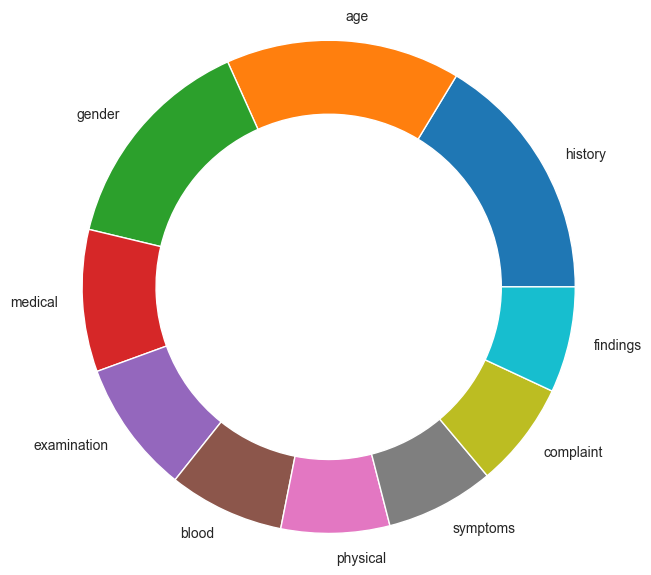

In [236]:
import matplotlib.pyplot as plt


# create data
# 创建数据
keep =10
size_of_groups = [temp[1] for temp in tf_list_[:keep]]
 
# Create a pieplot
# 创建饼图
plt.figure(figsize = (7,7))
plt.pie(size_of_groups, labels= [temp[0] for temp in tf_list_[:keep]], wedgeprops=dict(width=0.3, edgecolor='w'))

# 设置等比例轴，x和y轴等比例
plt.axis('equal') 
plt.savefig('画图/饼图/Oracle_top10.jpg')
plt.show()

In [9]:
tf_list

{'illness': 0.0003852922493778051,
 'Psychological': 4.16532161489519e-05,
 'Amylase': 2.082660807447595e-05,
 'Findings': 0.0001666128645958076,
 'Procedures': 2.082660807447595e-05,
 'anti-hypertensive': 1.0413304037237976e-05,
 'bit': 1.0413304037237976e-05,
 'initiation': 3.123991211171393e-05,
 'weakness': 2.082660807447595e-05,
 'Waiting': 1.0413304037237976e-05,
 'brought': 1.0413304037237976e-05,
 'Mg+': 6.247982422342785e-05,
 'bedwetting': 1.0413304037237976e-05,
 'night': 1.0413304037237976e-05,
 'vocabulary': 1.0413304037237976e-05,
 'Alkaline': 0.0001666128645958076,
 'infarction': 1.0413304037237976e-05,
 'onset': 0.0003228124251543772,
 'facial': 4.16532161489519e-05,
 'ingested': 1.0413304037237976e-05,
 'attempt': 1.0413304037237976e-05,
 'Circumstances': 6.247982422342785e-05,
 'Husband': 5.206652018618988e-05,
 'Port': 1.0413304037237976e-05,
 'tones': 1.0413304037237976e-05,
 'thought': 1.0413304037237976e-05,
 'protein': 9.371973633514177e-05,
 'Contraception': 5.2

In [72]:
from wordcloud import WordCloud
import numpy as np
data_dicts=np.load('/Users/yutong/Desktop/EMNLP最最终版/data/ORACLE/Oracle.npy',allow_pickle=True).item()
text = ''
for temp in data_dicts.values():
    text += ' \n'.join(temp['doctor_questions'])+' \n'
# Generate a word cloud image
word_tokens = word_tokenize(text)
filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
#with no lower case conversion
filtered_sentence = []
 
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

In [76]:
from wordcloud import WordCloud
import numpy as np
import re

data_dicts=np.load('/Users/yutong/Desktop/EMNLP最最终版/data/我们的模型/我们的模型_one_shot_集中回答_6轮_统一第一轮.npy',allow_pickle=True).item()
text = ''
for temp in data_dicts.values():
    questions = [pp['content'] for pp in temp['conversations'] if pp['role'] == 'doctor']
    text += ' \n'.join(questions)+' \n'
# Generate a word cloud image
word_tokens = word_tokenize(text)
filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
#with no lower case conversion
filtered_sentence = []
 
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

In [73]:
stop = ['Based','done','have','can','what','provide','important','possible','It', 'I','You','would','This','welcome','please','questions','s','meantime','know','re','Take','hesitate','provider','keep',
'great','in','if','let','do','information','aditionally','anything','taking','ever','tell','we','need','patient']


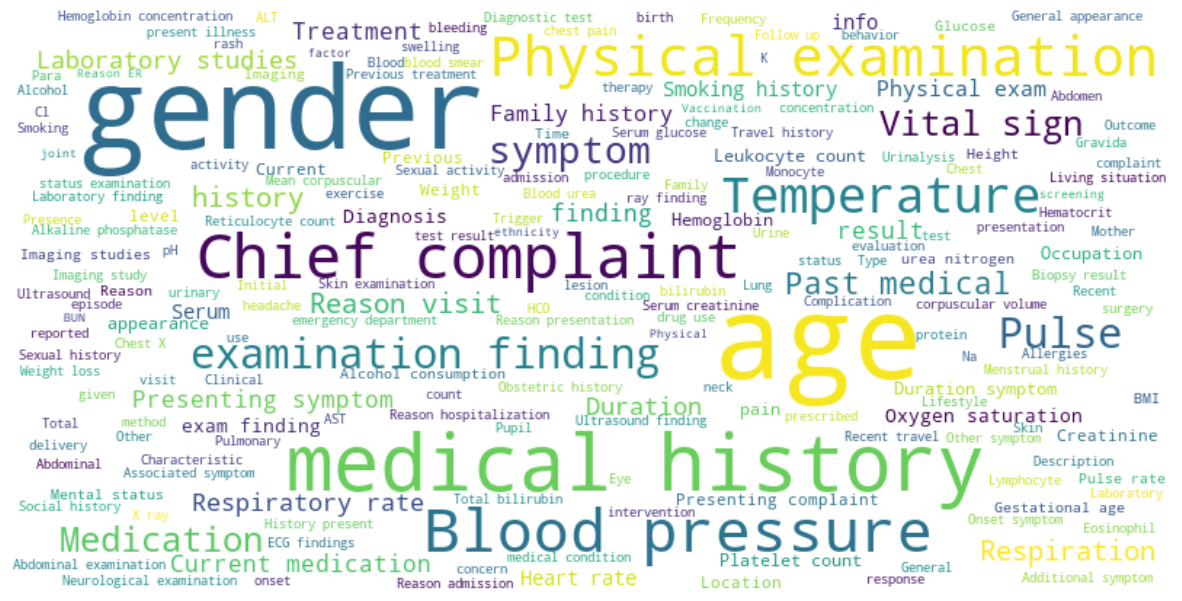

In [77]:
import matplotlib.pyplot as plt
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")

stop = ['Based','done','have','can','what','provide','important','possible','It', 'I','You','would','This','welcome','please','questions','s','meantime','know','re','Take','hesitate','provider','keep',
'great','in','if','let','do','information','aditionally','anything','taking','ever','tell','we','need','patient']
wordcloud = WordCloud(background_color='white',max_font_size=80,width=800, height=400,prefer_horizontal = 1, stopwords=stop,relative_scaling=0.8).generate(result)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('画图/词云/vicu-ft.pdf')
plt.show()

symptoms
medical
changes
tests
pain
blood
experienced
medications
conditions
history
recently
results
related
infections
surgeries
condition
illnesses
supplements
test
treatment


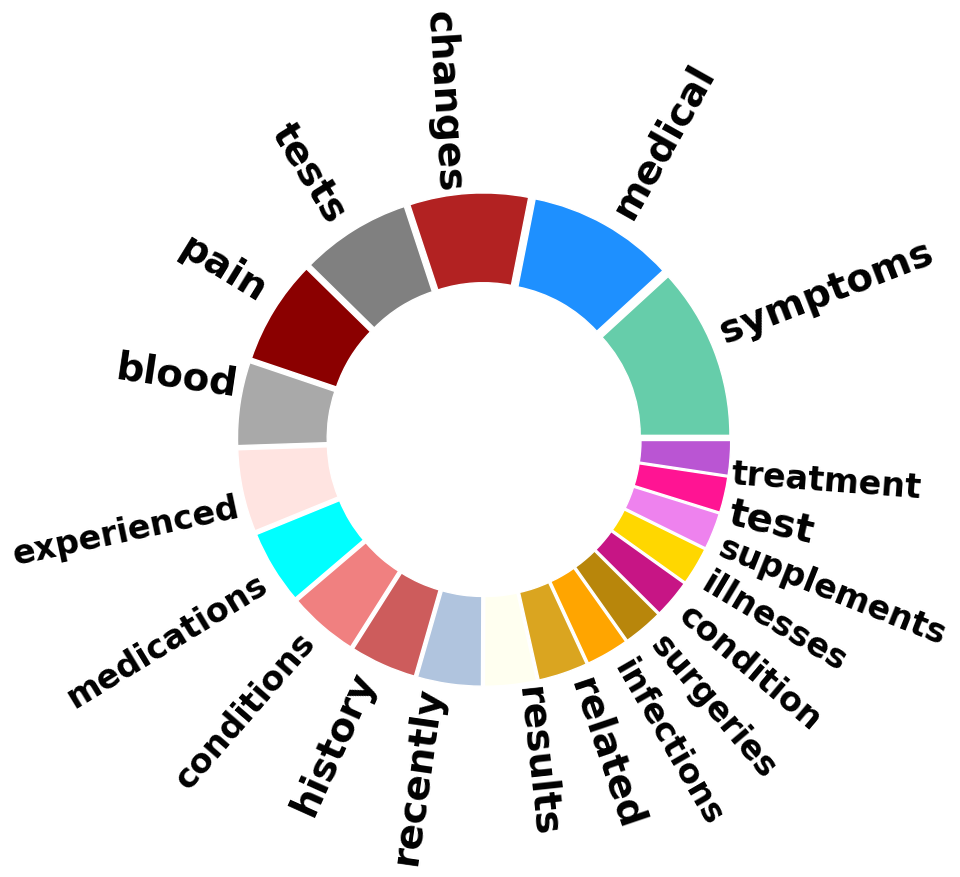

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import numpy as np
# book_list = json.load(open('/Users/yutong/Desktop/EMNLP最最终版/data/三百道/medical_info_usmle_test_firstquestion.json'))
# book_list = json.load(open('/Users/yutong/Desktop/EMNLP最最终版/data/medical_info_medqa_test_firstquestion.json'))
# book_list = json.load(open('/Users/yutong/Desktop/EMNLP最最终版/data/QMAX/medical_info_qmax_test_firstquestion.json'))

# generated_dict = data_dicts=np.load('/Users/yutong/Desktop/EMNLP最最终版/data/ChatGPT-Long/选择题_不集中.npy',allow_pickle=True).item()
generated_dict = data_dicts=np.load('/Users/yutong/Desktop/EMNLP最最终版/data/Vicuna/vicuna7b_medqa选择题_全部.npy',allow_pickle=True).item()
# generated_dict = data_dicts=np.load('/Users/yutong/Desktop/EMNLP最最终版/data/ChatGPT-Short/MedQA_选择题.npy',allow_pickle=True).item()
book_list = list(generated_dict.values())
text = ''


for temp in book_list:
    for key in temp['doctor_questions']:
        text += key

text = text.lower()
stop_words = set(stopwords.words('english'))
stop = ['Based','done','have','can','what','provide','important','possible','It', 'I','You','would','This','welcome','please','questions','s','meantime','know','re','Take','hesitate','provider','keep',
'great','in','if','let','do','information','aditionally','anything','taking','ever','tell','we','need','patient','Can','tell','me','you','could','recent','noticed','expienced','experiencing',
'about','?',"'s",',','Patient','(',')','.',"'m","' ",'’','#','may','based','recommend','help','also','seems','provided','info_1']
stop_words = set(list(stop_words)+stop)
word_tokens = word_tokenize(text)
# converts the words in word_tokens to lower case and then checks whether
#they are present in stop_words or not
filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
#with no lower case conversion
filtered_sentence = []
 
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
from nltk.text import TextCollection 
text_collection = TextCollection(filtered_sentence)
vocab = set([w for w in filtered_sentence])
tf_list = {}
for word in vocab:
    word_tf = text_collection.tf(word, filtered_sentence)
    tf_list[word] = word_tf
tf_list_ = sorted(tf_list.items(),key = lambda x:x[1],reverse = True)
import matplotlib.pyplot as plt


# create data
# 创建数据
keep =20
size_of_groups = [temp[1] for temp in tf_list_[:keep]]
labels = [temp[0] for temp in tf_list_[:keep]]
cnames = {'aliceblue': '#F0F8FF','antiquewhite': '#FAEBD7','aqua': '#00FFFF','aquamarine': '#7FFFD4','azure': '#F0FFFF','beige': '#F5F5DC','bisque': '#FFE4C4','black': '#000000','blanchedalmond': '#FFEBCD','blue': '#0000FF','blueviolet': '#8A2BE2','brown': '#A52A2A','burlywood': '#DEB887','cadetblue': '#5F9EA0','chartreuse': '#7FFF00','chocolate': '#D2691E','coral': '#FF7F50','cornflowerblue': '#6495ED','cornsilk': '#FFF8DC','crimson': '#DC143C','cyan': '#00FFFF','darkblue': '#00008B','darkcyan': '#008B8B','darkgoldenrod': '#B8860B','darkgray': '#A9A9A9','darkgreen': '#006400','darkkhaki': '#BDB76B','darkmagenta': '#8B008B','darkolivegreen': '#556B2F','darkorange': '#FF8C00','darkorchid': '#9932CC','darkred': '#8B0000','darksalmon': '#E9967A','darkseagreen': '#8FBC8F','darkslateblue': '#483D8B','darkslategray': '#2F4F4F','darkturquoise': '#00CED1','darkviolet': '#9400D3','deeppink': '#FF1493','deepskyblue': '#00BFFF','dimgray': '#696969','dodgerblue': '#1E90FF','firebrick': '#B22222','floralwhite': '#FFFAF0','forestgreen': '#228B22','fuchsia': '#FF00FF','gainsboro': '#DCDCDC','ghostwhite': '#F8F8FF','gold': '#FFD700','goldenrod': '#DAA520','gray': '#808080','green': '#008000','greenyellow': '#ADFF2F','honeydew': '#F0FFF0','hotpink': '#FF69B4','indianred': '#CD5C5C','indigo': '#4B0082','ivory': '#FFFFF0','khaki': '#F0E68C','lavender': '#E6E6FA','lavenderblush': '#FFF0F5','lawngreen': '#7CFC00','lemonchiffon': '#FFFACD','lightblue': '#ADD8E6','lightcoral': '#F08080','lightcyan': '#E0FFFF','lightgoldenrodyellow': '#FAFAD2','lightgreen': '#90EE90','lightgray': '#D3D3D3','lightpink': '#FFB6C1','lightsalmon': '#FFA07A','lightseagreen': '#20B2AA','lightskyblue': '#87CEFA','lightslategray': '#778899','lightsteelblue': '#B0C4DE','lightyellow': '#FFFFE0','lime': '#00FF00','limegreen': '#32CD32','linen': '#FAF0E6','magenta': '#FF00FF','maroon': '#800000','mediumaquamarine': '#66CDAA','mediumblue': '#0000CD','mediumorchid': '#BA55D3','mediumpurple': '#9370DB','mediumseagreen': '#3CB371','mediumslateblue': '#7B68EE','mediumspringgreen': '#00FA9A','mediumturquoise': '#48D1CC','mediumvioletred': '#C71585','midnightblue': '#191970','mintcream': '#F5FFFA','mistyrose': '#FFE4E1','moccasin': '#FFE4B5','navajowhite': '#FFDEAD','navy': '#000080','oldlace': '#FDF5E6','olive': '#808000','olivedrab': '#6B8E23','orange': '#FFA500','orangered': '#FF4500','orchid': '#DA70D6','palegoldenrod': '#EEE8AA','palegreen': '#98FB98','paleturquoise': '#AFEEEE','palevioletred': '#DB7093','papayawhip': '#FFEFD5','peachpuff': '#FFDAB9','peru': '#CD853F','pink': '#FFC0CB','plum': '#DDA0DD','powderblue': '#B0E0E6','purple': '#800080','red': '#FF0000','rosybrown': '#BC8F8F','royalblue': '#4169E1','saddlebrown': '#8B4513','salmon': '#FA8072','sandybrown': '#FAA460','seagreen': '#2E8B57','seashell': '#FFF5EE','sienna': '#A0522D','silver': '#C0C0C0','skyblue': '#87CEEB','slateblue': '#6A5ACD','slategray': '#708090','snow': '#FFFAFA','springgreen': '#00FF7F','steelblue': '#4682B4','tan': '#D2B48C','teal': '#008080','thistle': '#D8BFD8','tomato': '#FF6347','turquoise': '#40E0D0','violet': '#EE82EE','wheat': '#F5DEB3','white': '#FFFFFF','whitesmoke': '#F5F5F5','yellow': '#FFFF00','yellowgreen': '#9ACD32'}
colors = [  list(cnames.keys())[hash(temp)%len(cnames.keys())] for temp in labels]
# Create a pieplot
# 创建饼图
plt.figure(figsize = (7,7))

patches,l_text = plt.pie( size_of_groups, labels= labels, wedgeprops=dict(width=0.382, edgecolor='w'),labeldistance=1, explode=[0.05]*keep,colors=colors,rotatelabels=True)

# for t in p_text:
#     t.set_size(5)

for t in l_text:
    print(t.get_text())
    if '\n' in t.get_text() or len(t.get_text())>8:
        t.set_size(24)
        t.set(fontweight='bold')
    else:
        t.set_size(28)
        t.set(fontweight='bold')
    # t.set(color=)
# 设置等比例轴，x和y轴等比例
plt.axis('equal') 
plt.savefig('饼图/ChatGPT_long_top20.pdf',bbox_inches = 'tight')
# plt.savefig('饼图/ChatGPT_Short_top20.pdf',bbox_inches = 'tight')
# plt.savefig('画图/饼图/Sample_test_data.pdf',bbox_inches = 'tight')
plt.show()  

history
age
gender
medical
examination
blood
physical
symptoms
complaint
findings
chief
pressure
temperature
reason
pulse
rate
medications
vital
signs
serum


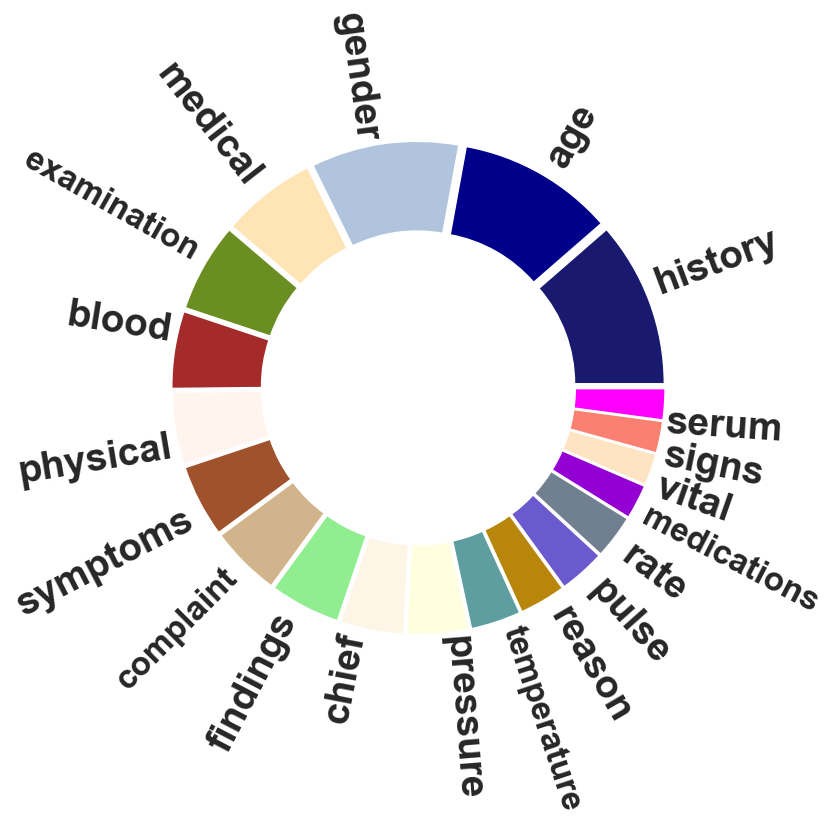

In [462]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import numpy as np
# book_list = json.load(open('/Users/yutong/Desktop/EMNLP最最终版/data/三百道/medical_info_usmle_test_firstquestion.json'))
# book_list = json.load(open('/Users/yutong/Desktop/EMNLP最最终版/data/medical_info_medqa_test_firstquestion.json'))
# book_list = json.load(open('/Users/yutong/Desktop/EMNLP最最终版/data/QMAX/medical_info_qmax_test_firstquestion.json'))

book_list = np.load('/Users/yutong/Desktop/EMNLP最最终版/data/ChatGPT-Long/选择题_不集中.npy',allow_pickle=True).item()

text = ''

for temp in book_list:
    for key in temp['medical_info_list'].keys():
        text += key+' '

text = text.lower()
stop_words = set(stopwords.words('english'))
stop = ['Based','done','have','can','what','provide','important','possible','It', 'I','You','would','This','welcome','please','questions','s','meantime','know','re','Take','hesitate','provider','keep',
'great','in','if','let','do','information','aditionally','anything','taking','ever','tell','we','need','patient','Can','tell','me','you','could','recent','noticed','expienced','experiencing',
'about','?',"'s",',','Patient','(',')','.',"'m","' ",'’','#','may','based','recommend','help','also','seems','provided','info_1']
stop_words = set(list(stop_words)+stop)
word_tokens = word_tokenize(text)
# converts the words in word_tokens to lower case and then checks whether
#they are present in stop_words or not
filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
#with no lower case conversion
filtered_sentence = []
 
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
from nltk.text import TextCollection 
text_collection = TextCollection(filtered_sentence)
vocab = set([w for w in filtered_sentence])
tf_list = {}
for word in vocab:
    word_tf = text_collection.tf(word, filtered_sentence)
    tf_list[word] = word_tf
tf_list_ = sorted(tf_list.items(),key = lambda x:x[1],reverse = True)
import matplotlib.pyplot as plt


# create data
# 创建数据
keep =20
size_of_groups = [temp[1] for temp in tf_list_[:keep]]
labels = [temp[0] for temp in tf_list_[:keep]]
cnames = {'aliceblue': '#F0F8FF','antiquewhite': '#FAEBD7','aqua': '#00FFFF','aquamarine': '#7FFFD4','azure': '#F0FFFF','beige': '#F5F5DC','bisque': '#FFE4C4','black': '#000000','blanchedalmond': '#FFEBCD','blue': '#0000FF','blueviolet': '#8A2BE2','brown': '#A52A2A','burlywood': '#DEB887','cadetblue': '#5F9EA0','chartreuse': '#7FFF00','chocolate': '#D2691E','coral': '#FF7F50','cornflowerblue': '#6495ED','cornsilk': '#FFF8DC','crimson': '#DC143C','cyan': '#00FFFF','darkblue': '#00008B','darkcyan': '#008B8B','darkgoldenrod': '#B8860B','darkgray': '#A9A9A9','darkgreen': '#006400','darkkhaki': '#BDB76B','darkmagenta': '#8B008B','darkolivegreen': '#556B2F','darkorange': '#FF8C00','darkorchid': '#9932CC','darkred': '#8B0000','darksalmon': '#E9967A','darkseagreen': '#8FBC8F','darkslateblue': '#483D8B','darkslategray': '#2F4F4F','darkturquoise': '#00CED1','darkviolet': '#9400D3','deeppink': '#FF1493','deepskyblue': '#00BFFF','dimgray': '#696969','dodgerblue': '#1E90FF','firebrick': '#B22222','floralwhite': '#FFFAF0','forestgreen': '#228B22','fuchsia': '#FF00FF','gainsboro': '#DCDCDC','ghostwhite': '#F8F8FF','gold': '#FFD700','goldenrod': '#DAA520','gray': '#808080','green': '#008000','greenyellow': '#ADFF2F','honeydew': '#F0FFF0','hotpink': '#FF69B4','indianred': '#CD5C5C','indigo': '#4B0082','ivory': '#FFFFF0','khaki': '#F0E68C','lavender': '#E6E6FA','lavenderblush': '#FFF0F5','lawngreen': '#7CFC00','lemonchiffon': '#FFFACD','lightblue': '#ADD8E6','lightcoral': '#F08080','lightcyan': '#E0FFFF','lightgoldenrodyellow': '#FAFAD2','lightgreen': '#90EE90','lightgray': '#D3D3D3','lightpink': '#FFB6C1','lightsalmon': '#FFA07A','lightseagreen': '#20B2AA','lightskyblue': '#87CEFA','lightslategray': '#778899','lightsteelblue': '#B0C4DE','lightyellow': '#FFFFE0','lime': '#00FF00','limegreen': '#32CD32','linen': '#FAF0E6','magenta': '#FF00FF','maroon': '#800000','mediumaquamarine': '#66CDAA','mediumblue': '#0000CD','mediumorchid': '#BA55D3','mediumpurple': '#9370DB','mediumseagreen': '#3CB371','mediumslateblue': '#7B68EE','mediumspringgreen': '#00FA9A','mediumturquoise': '#48D1CC','mediumvioletred': '#C71585','midnightblue': '#191970','mintcream': '#F5FFFA','mistyrose': '#FFE4E1','moccasin': '#FFE4B5','navajowhite': '#FFDEAD','navy': '#000080','oldlace': '#FDF5E6','olive': '#808000','olivedrab': '#6B8E23','orange': '#FFA500','orangered': '#FF4500','orchid': '#DA70D6','palegoldenrod': '#EEE8AA','palegreen': '#98FB98','paleturquoise': '#AFEEEE','palevioletred': '#DB7093','papayawhip': '#FFEFD5','peachpuff': '#FFDAB9','peru': '#CD853F','pink': '#FFC0CB','plum': '#DDA0DD','powderblue': '#B0E0E6','purple': '#800080','red': '#FF0000','rosybrown': '#BC8F8F','royalblue': '#4169E1','saddlebrown': '#8B4513','salmon': '#FA8072','sandybrown': '#FAA460','seagreen': '#2E8B57','seashell': '#FFF5EE','sienna': '#A0522D','silver': '#C0C0C0','skyblue': '#87CEEB','slateblue': '#6A5ACD','slategray': '#708090','snow': '#FFFAFA','springgreen': '#00FF7F','steelblue': '#4682B4','tan': '#D2B48C','teal': '#008080','thistle': '#D8BFD8','tomato': '#FF6347','turquoise': '#40E0D0','violet': '#EE82EE','wheat': '#F5DEB3','white': '#FFFFFF','whitesmoke': '#F5F5F5','yellow': '#FFFF00','yellowgreen': '#9ACD32'}
colors = [  list(cnames.keys())[hash(temp)%len(cnames.keys())] for temp in labels]
# Create a pieplot
# 创建饼图
plt.figure(figsize = (7,7))

patches,l_text = plt.pie( size_of_groups, labels= labels, wedgeprops=dict(width=0.382, edgecolor='w'),labeldistance=1, explode=[0.05]*keep,colors=colors,rotatelabels=True)

# for t in p_text:
#     t.set_size(5)

for t in l_text:
    print(t.get_text())

    if '\n' in t.get_text() or len(t.get_text())>8:
        t.set_size(24)
        t.set(fontweight='bold')
    else:
        t.set_size(28)
        t.set(fontweight='bold')
    # t.set(color=)
# 设置等比例轴，x和y轴等比例
plt.axis('equal') 
# plt.savefig('画图/饼图/QMAX_data.pdf',bbox_inches = 'tight')
plt.savefig('画图/饼图/MedQA_data.pdf',bbox_inches = 'tight')
# plt.savefig('画图/饼图/Sample_test_data.pdf',bbox_inches = 'tight')
plt.show()  